# Sidhu x Drake: A Quick Exploration

Drake and Sidhu Moose Wala never got a chance to collaborate on a song together, but that's not to say their music isn't compatible. Having danced to Bhangra mixes featuring songs from Punjabi artists like Sidhu and Western rap samples from artists like Drake, I was curious to use Spotify's API to get an idea of which of their songs might pair nicely together in a mix, according to some simple metric of musical compatibility.

For my quick exploration, I only used a handful of song-level features to describe each track: tempo (e.g. BPM), time_signature (e.g. the numerator of 4/4), key (e.g. C), and mode (e.g. major/minor). Each of these fields was coded as a float by Spotify, so I compared similarity between vectors in $\mathbb{R}^4$. After finding high-level song similarity, it would make sense to take a more granular look at the compatibility between within-song segments (defined as snippets of a song like a chorus, new instrument introduction, etc.) for mixing purposes. However, without computing power or clever vectorization, an exhaustive search across all possible segment pairs would quickly become intractable (for example, Spotify stores 747 segments for Ammy Virk's "Solid" alone). It would also be interesting to access the raw audio file, as well as transforms of the audio data using techniques like FFT's, in addition to higher level hand-coded features. 

I computed vector similarity using three common distance metrics: cosine similarity, euclidean distance, and manhattan distance. I also looked for clusters in $\mathbb{R}^2$ after reducing each vector to its top 2 principal components from PCA.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [2]:
client_id = 'e32db2ab4299473088394f2a020cf8c6'
client_secret = '6cb63b4390594ec8ad41a01782a3f84d'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [4]:
def euclidean_distance(a, b):
    distance = np.linalg.norm(a - b)
    return distance

In [5]:
def manhattan_distance(a, b):
    distance = np.sum(np.abs(a - b))
    return distance

In [6]:
def get_high_level_song_features(artist_name, top=50):
    results = sp.search(q=artist_name, type='artist')
    artist_results = results['artists']['items'][0] 
    artist_id = artist_results['id']
    
    high_level_song_features = []

    albums = sp.artist_albums(artist_id, album_type='album')
    for album in albums['items']:
        album_id = album['id']
        album_name = album['name']
        tracks = sp.album_tracks(album_id)

        for track in tracks['items']:
            track_id = track['id']
            track_name = track['name']
            audio_analysis = sp.audio_analysis(track_id)
            features = np.array([audio_analysis["track"]["tempo"], 
                                 audio_analysis["track"]["time_signature"],
                                 audio_analysis["track"]["key"],
                                 audio_analysis["track"]["mode"]])
            high_level_song_features.append((track_name, features))
    
    return high_level_song_features

In [7]:
def get_most_compatible_pairs(artist_1, artist_2, metric):
    pairs = []
    songs_1 = get_high_level_song_features(artist_1)[:10]
    songs_2 = get_high_level_song_features(artist_2)[:10]
    for song_1 in songs_1:
        for song_2 in songs_2:
            if metric == "manhattan":
                sim = manhattan_distance(song_1[1], song_2[1])
                rev = False
            elif metric == "euclidean":
                sim = euclidean_distance(song_1[1], song_2[1])
                rev = False
            elif metric == "cosine":
                sim = cosine_similarity(song_1[1], song_2[1])
                rev = True
            pairs.append((song_1[0], 
                          song_2[0], 
                          sim))            
    pairs_sorted = sorted(pairs, key=lambda x: x[-1], reverse=rev)[:10]
    return pairs_sorted

Below we see that the distance metric has an effect on the rankings of pairs of songs. However, the small dimension of our vector space and common values of features (for example, most songs are in 4/4 time) also appears to inflate similarity metrics, implying that we need more descriptive features. 

In [8]:
cosine_pairs = get_most_compatible_pairs("Sidhu Moose Wala", "Drake", "cosine")
for pair in cosine_pairs:
    print("Cosine Similarity between \"" + pair[0] + "\" and \"" + pair[1] + "\": " + str(pair[2]))

Cosine Similarity between "Moosedrilla (feat. DIVINE)" and "Calling For You (feat. 21 Savage)": 0.9999911869693228
Cosine Similarity between "Aroma" and "First Person Shooter (feat. J. Cole)": 0.9999861776631902
Cosine Similarity between "Moosedrilla (feat. DIVINE)" and "Amen (feat. Teezo Touchdown)": 0.9999834857714455
Cosine Similarity between "Burberry" and "Daylight": 0.9999750874473244
Cosine Similarity between "Burberry" and "7969 Santa": 0.9999743862387908
Cosine Similarity between "Aroma" and "7969 Santa": 0.9999734926299801
Cosine Similarity between "Bitch I'm Back" and "First Person Shooter (feat. J. Cole)": 0.999973000202276
Cosine Similarity between "Bitch I'm Back" and "IDGAF (feat. Yeat)": 0.9999689463980025
Cosine Similarity between "Bitch I'm Back" and "Slime You Out (feat. SZA)": 0.9999679737249375
Cosine Similarity between "Aroma" and "Daylight": 0.9999677722929768


In [10]:
euclidean_pairs = get_most_compatible_pairs("Sidhu Moose Wala", "Drake", "euclidean")
for pair in euclidean_pairs:
    print("Euclidean Distance between \"" + pair[0] + "\" and \"" + pair[1] + "\": " + str(pair[2]))

Euclidean Distance between "Aroma" and "7969 Santa": 1.1379143201489188
Euclidean Distance between "Racks and Rounds (feat. Sikander Kahlon)" and "Slime You Out (feat. SZA)": 1.322859024990947
Euclidean Distance between "Aroma" and "Daylight": 2.2468075128946854
Euclidean Distance between "Brown Shortie (feat. Sonam Bajwa)" and "Slime You Out (feat. SZA)": 3.371433078084159
Euclidean Distance between "Aroma" and "IDGAF (feat. Yeat)": 5.2250263157232055
Euclidean Distance between "Aroma" and "Fear Of Heights": 5.34433681573307
Euclidean Distance between "Racks and Rounds (feat. Sikander Kahlon)" and "Amen (feat. Teezo Touchdown)": 5.620334865468431
Euclidean Distance between "Moosedrilla (feat. DIVINE)" and "Fear Of Heights": 7.138381048949405
Euclidean Distance between "Moosedrilla (feat. DIVINE)" and "IDGAF (feat. Yeat)": 8.068872535862743
Euclidean Distance between "Brown Shortie (feat. Sonam Bajwa)" and "Amen (feat. Teezo Touchdown)": 8.124743011320419


In [11]:
manhattan_pairs = get_most_compatible_pairs("Sidhu Moose Wala", "Drake", "manhattan")
for pair in manhattan_pairs:
    print("Manhattan Distance between \"" + pair[0] + "\" and \"" + pair[1] + "\": " + str(pair[2]))

Manhattan Distance between "Aroma" and "7969 Santa": 1.542999999999978
Manhattan Distance between "Racks and Rounds (feat. Sikander Kahlon)" and "Slime You Out (feat. SZA)": 1.8659999999999997
Manhattan Distance between "Aroma" and "Daylight": 3.0120000000000005
Manhattan Distance between "Brown Shortie (feat. Sonam Bajwa)" and "Slime You Out (feat. SZA)": 5.169000000000011
Manhattan Distance between "Aroma" and "Fear Of Heights": 6.955999999999989
Manhattan Distance between "Aroma" and "IDGAF (feat. Yeat)": 7.030000000000001
Manhattan Distance between "Moosedrilla (feat. DIVINE)" and "Fear Of Heights": 8.978000000000009
Manhattan Distance between "Moosedrilla (feat. DIVINE)" and "IDGAF (feat. Yeat)": 9.052000000000021
Manhattan Distance between "Racks and Rounds (feat. Sikander Kahlon)" and "Amen (feat. Teezo Touchdown)": 9.14200000000001
Manhattan Distance between "Bitch I'm Back" and "7969 Santa": 9.439999999999998


In [12]:
sidhu_features = get_high_level_song_features("Sidhu Moose Wala")
sidhu_features_array = np.array([song[1] for song in sidhu_features])
sidhu_names = [song[0] for song in sidhu_features]

drake_features = get_high_level_song_features("Drake")
drake_features_array = np.array([song[1] for song in drake_features])
drake_names = [song[0] for song in drake_features]

In [13]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(sidhu_features_array)
pc_sidhu = np.array([principal_components[:, 0], principal_components[:, 1]]).T

In [14]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(drake_features_array)
pc_drake = np.array([principal_components[:, 0], principal_components[:, 1]]).T

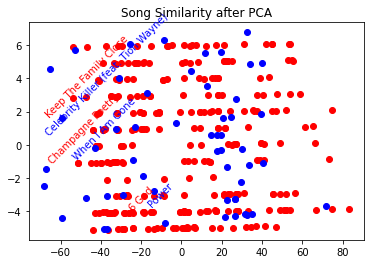

In [16]:
distances = []
for drake_point in pc_drake:
    for sidhu_point in pc_sidhu:
        distance = np.sqrt(np.sum((drake_point - sidhu_point)**2))
        distances.append(distance)

threshold = 0.32 # reduced threshold to not clutter display

plt.scatter(pc_drake[:,0], pc_drake[:,1], color = "red")
plt.scatter(pc_sidhu[:,0], pc_sidhu[:,1], color = "blue")

for drake_name, drake_point in zip(drake_names, pc_drake):
    for sidhu_name, sidhu_point in zip(sidhu_names, pc_sidhu):
        distance = np.sqrt(np.sum((drake_point - sidhu_point)** 2))
        if distance < threshold:
            x = (drake_point[0] + sidhu_point[0])/2
            y = (drake_point[1] + sidhu_point[1])/2
            plt.annotate(drake_name, (drake_point[0], drake_point[1]), xytext=(x, y), 
                         textcoords='offset points', ha='center', va='center', rotation=45, color="red")
            plt.annotate(sidhu_name, (sidhu_point[0], sidhu_point[1]), xytext=(x + 20, y), 
                         textcoords='offset points', ha='center', va='center', rotation=45, color="blue")
plt.title("Song Similarity after PCA")
plt.show()

Above we see a plot of the features each of Drake and Sidhu's top songs, reduced into two dimensions through PCA. The patterns and groupings of datapoints in this plot again highlights the need for more complex features, while still giving us some idea of similar songs as shown through the labeled points. 